# Summer Research Week \# 1
## Finite Differences

#### Executive Summary:
In this Jupyter Notebook, we develop a few python classes -- grid, time, and pde -- to make the subsequent code more robust. In the following code, we impliment the forward Euler (FE), backward Euler (BE), and Crank - Nicholson (CN) for the advection and diffusion equation in 1 spatial dimension. We are able to accomdate Dirichlet, Neumann, and Robin boundary conditions. Additionally, we can accomadate non homogenous PDEs. A brief discussion of Periodic conditions are mentioned as well, as we are still working on an effective way of performing the linear solve at each time step.

There is also code that properly sets up the difference operator for first and second derivatives. We use the forward, backward, and centered difference scheme for the first derivative, and the second order (1,-2,1) scheme for the second derivative in up to 3 spatial dimensions using the direct sum of Kronecker products. However, it is easily extendable to a finite amount of dimensions (like 6 if need be). There is also an option to perform these difference operators in a sparse format to save on memory. While we do have these codes, we have not yet performed these computations in 2 or 3 spatial dimensions. 

### Linear Advection equation
\begin{align}
\frac{\partial}{\partial t} u(x,t)+ a \frac{\partial}{\partial x} u(x,t) &= 0\\
u(x,0) &= u_0(x)\\
u(0,t) &= u_l(t)\\
u(L,t) &= u_r(t)
\end{align}

where $u(x,t) : \mathbb{R}^{1+1} \to\mathbb{R}, a\in\mathbb{R}$

First way, I will attempt to solve this is the semidiscrete method, where we discretize the spatial elements using a finite difference scheme, and then treat the time continuously, so that we have a system of linear ODEs which we will plan to solve.

%% We know that $u(t,x) = u_0(x-at)$, where $u_0(x) = u(0,x), \forall x\in\mathbb{R}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg as spla
from scipy.sparse import dia_array
from scipy.sparse.linalg import gmres
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [2]:
np.random.seed(12345)

In [3]:
def tridiag(a,b,c,n,*, is_sparse: bool = False):
    # Make a tridiagonal matrix, which is common in FDM
    
    if is_sparse == False:
        # Create an n x n tridiagonal matrix with subdiagonal a, diagonal b, and superdiagonal c
        A = np.diag(a * np.ones(n-1), -1) + np.diag(b * np.ones(n)) + np.diag(c * np.ones(n-1), 1)
    else:
        # An Attempt to make a sparse matrix structure. 
        ## Need to test
        ex = np.ones(n)
        data = np.array([a * ex, b * ex, c * ex])
        offsets = np.array([-1, 0, 1])
        A = dia_array((data, offsets), shape=(n, n))
        
        
    return A
    

In [4]:
A = tridiag(1,2,3,5)

print(A)

[[2. 3. 0. 0. 0.]
 [1. 2. 3. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 0. 1. 2. 3.]
 [0. 0. 0. 1. 2.]]


In [5]:
def fd3df(nx, ny, nz, alpx = 0, alpy = 0, alpz = 0, dshift = 0, *, is_sparse: bool = False): 
    # First order Forward Method

    if is_sparse == False:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(0, -1, 1, nx)
        ty = tridiag(0, -1, 1, ny)
        tz = tridiag(0, -1, 1, nz)
        A = tx
        if ny > 1:
            A = np.kron(np.eye(ny), A) + np.kron(ty,np.eye(nx))
            if nz > 1:
                A = np.kron(np.eye(nz), A) + np.kron(tz,np.eye(nx * ny))
    
        A -= dshift * np.eye(nx * ny * nz)
    else:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(0, -1, 1, nx, is_sparse = True)
        ty = tridiag(0, -1, 1, ny, is_sparse = True)
        tz = tridiag(0, -1, 1, nz, is_sparse = True)

        # Create sparse kroneckers
        A = tx
        if ny > 1:
            A = sp.sparse.kron(sp.sparse.identity(ny),A) + sp.sparse.kron(ty,sp.sparse.identity(nx))
            if nz > 1:
                A = sp.sparse.kron(sp.sparse.identity(nz),A) + sp.sparse.kron(tz,sp.sparse.identity(nx * ny))

        A -= dshift * sp.sparse.identity(nx * ny * nz)
    return A
    

In [6]:
A = fd3df(2,3,2)

print(A)

[[-3.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -3.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -3.  1.  1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -3.  0.  1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -3.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -3.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -3.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -3.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.]]


In [7]:
def fd3dc(nx, ny, nz, dshift = 0, *, is_sparse: bool = False): #,ny,nz, alpx = 0, alpy = 0, alpz = 0, dshift = 0):
    # First order Forward Method

    if is_sparse == False:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(-0.5, 0, 0.5, nx)
        # If there is enough gridpoints, we use a second order forward method for the left point,
        # and second order backward method for the right point. Now all O(h^2)
        if nx > 2:
            tx[0, :3] = np.array([-1.5,2,-0.5])
            tx[nx-1,-3:] = np.array([0.5,-2,1.5])
    
        A = tx
        if ny > 1:
            ty = tridiag(-0.5, 0, 0.5, ny)
            if ny > 2:
                ty[0, :3] = np.array([-1.5,2,-0.5])
                ty[ny-1,-3:] = np.array([0.5,-2,1.5])
            A = np.kron(np.eye(ny), A) + np.kron(ty,np.eye(nx))
            if nz > 1:
                tz = tridiag(-0.5, 0, 0.5, nz)
                if nz > 2:
                    tz[0, 0:3] = np.array([-1.5,2,-0.5])
                    tz[nz-1,-3:] = np.array([0.5,-2,1.5])
                    A = np.kron(np.eye(nz), A) + np.kron(tz,np.eye(nx * ny))
    
        A -= dshift * np.eye(nx * ny * nz)
    else:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(0, -1, 1, nx, is_sparse = True)
        ty = tridiag(0, -1, 1, ny, is_sparse = True)
        tz = tridiag(0, -1, 1, nz, is_sparse = True)

        # Create sparse kroneckers
        A = tx
        if ny > 1:
            A = sp.sparse.kron(sp.sparse.identity(ny),A) + sp.sparse.kron(ty,sp.sparse.identity(nx))
            if nz > 1:
                A = sp.sparse.kron(sp.sparse.identity(nz),A) + sp.sparse.kron(tz,sp.sparse.identity(nx * ny))

        A -= dshift * sp.sparse.identity(nx * ny * nz)
    return A
    

In [8]:
A = fd3dc(3,2,1, dshift = 0)

print(A)

[[-1.5  2.  -0.5  0.5  0.   0. ]
 [-0.5  0.   0.5  0.   0.5  0. ]
 [ 0.5 -2.   1.5  0.   0.   0.5]
 [-0.5  0.  -0.  -1.5  2.  -0.5]
 [-0.  -0.5  0.  -0.5  0.   0.5]
 [ 0.  -0.  -0.5  0.5 -2.   1.5]]


In [9]:
class fd1dGrid:
    """
    a finite-difference grid
    """

    def __init__(self, nx, ng = 1, xmin=0.0, xmax=1.0):
        """
        create a 1D grid with (nx + 1) points that runs from [xmin, xmax].
        Additionally calculates dx and the x values where the solution is computed.
        """

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx)
        self.xpts = np.linspace(xmin, xmax, num = nx + 1)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]

        # storage for the solution
        # self.sol = np.zeros(nx + 1, dtype=np.float64)
        
        
    #def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
    #    return np.zeros((self.nx+2*self.ng), dtype=np.float64)

In [10]:
class advectionPDE:
    """
    a way to store all of the information of the PDE
    """
    
    def __init__(self, init_cond, bndy_cond, bndy_type, dim = 1, a = 1., source = 0):
        self.a = a
        self.init_cond = init_cond
        self.bndy_type = bndy_type
        if a > 0:
            self.bndy_cond = bndy_cond
        self.dim = dim
        self.source = source # homogenous if f := 0

In [11]:
def advec_FE_1D(grid, pde):
    
    # Grid Params
    n = grid.nx
    dx = grid.dx
    xpts = grid.xpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    C = 0.29
    dt = C * grid.dx / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda x: np.exp(x) 
    # b = lambda x: np.exp(x) * np.sin(1)
    al = pde.bndy_cond
    if bc == 'Neumann':
        mu = al
        nu = ar
        al = lambda x : 0
        ar = al
        bc = 'Robin'
        print('Successsss.')

    # Solution and applying IC, BCs
    u = np.zeros((n+1, maxk + 1), dtype = float)
    u[:,0] = f(xpts)
    u[0,:] = al(tpts)
    

    if bc == 'Dirichlet':
        # Constructing (I + cL) where L is the difference operator with bc
        IpcL = C * fd3df(n+1,1,1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I + cL).
        IpcL[0,:4] = 0
        IpcL[n,-4:] = 0
        IpcL += np.eye(n + 1)

        for k in range(maxk):
            # Applying the difference operator to the solution, then applying BCs
            u[:,k+1] =  np.dot(IpcL, u[:,k]) + dt * source(xpts,tpts[k])
            u[0,k+1] = al(tpts[k+1])
    elif bc == 'Robin':
        L = fd3df(n+1,1,1)
        for k in range(maxk):
            # Constructing the difference operator with bc. 
            L[0,0:2] = np.array([-2 * (1 + dx * a(tpts[k])), 2])
            L[n,n-2:n] = np.array([2, -2 * (1 + dx * b(tpts[k]))])
            
            # Difference operator update through time
            IpcL = np.eye(n+1) + C * L
            u[:,k+1] =  np.dot(IpcL, u[:,k]) + dt * source(xpts,tpts[k+1])
            
            # Applying BC for Neumann term
            u[0,k+1] = -2* (dt / dx) * mu(tpts[k])
            u[n,k+1] = -2* (dt / dx) * nu(tpts[k])
    else: # Periodic
        print('Need to do this still')
    
        
    
    return xpts, u

In [12]:
def plotPDE(xpts, u):
    plt.plot(xpts,u[:,0], label = 'initial') 
    plt.plot(xpts, u[:,9], label = 't = 9')
    plt.plot(xpts, u[:,29], label = 't = 29')
    plt.plot(xpts, u[:,44], label = 't = 44')
    plt.plot(xpts, u[:,59], label = 't = 59')
    plt.xlabel('x')
    plt.ylabel('Temp')
    plt.title('Temperature over Time')
    plt.legend()
    plt.show()

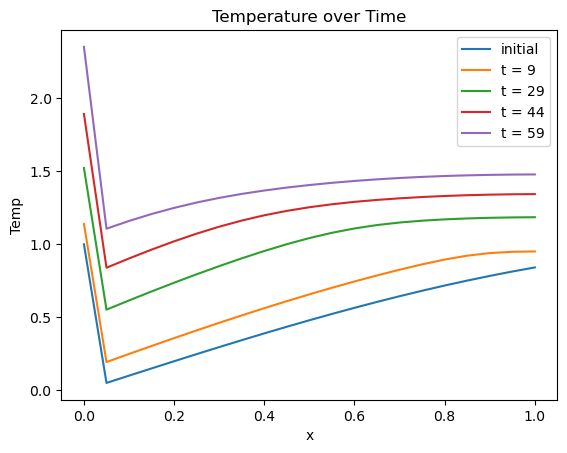

In [40]:
grid = fd1dGrid(20)
pde = advectionPDE(lambda x : np.sin(x), lambda t: np.exp(t), bndy_type = 'Dirichlet', source = lambda x,t: np.sin(x)*np.cos(t))
xpts, u = advec_FE_1D(grid, pde)

plotPDE(xpts, u)

In [14]:
def advec_BE_1D(grid, pde):
    
    # Grid Params
    n = grid.nx
    dx = grid.dx
    xpts = grid.xpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    C = 0.29
    dt = C * grid.dx / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda x: np.exp(x) 
    # b = lambda x: np.exp(x) * np.sin(1)
    al = pde.bndy_cond
    if bc == 'Neumann':
        mu = al
        nu = ar
        al = lambda x : 0
        ar = al
        bc = 'Robin'
        print('Successsss.')

    # Solution and applying IC, BCs
    u = np.zeros((n+1, maxk + 1), dtype = float)
    u[:,0] = f(xpts)
    u[0,:] = al(tpts)
    

    if bc == 'Dirichlet':
        # Constructing Difference Operator
        ImcL = C * fd3df(n+1,1,1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I + cL).
        ImcL[0,:4] = 0
        ImcL[n,-4:] = 0
        ImcL -= np.eye(n + 1)

        # For Banded Solve (Note because bc, I-cL NOT symmetric)
        supdiag = np.append([0], np.diag(ImcL,1))
        subdiag = np.append(np.diag(ImcL,-1),[0])
        ab = np.array([supdiag, np.diag(ImcL), subdiag])
        for k in range(maxk):
            # Update BCs for solution
            u[:,k] += dt * source(xpts,tpts[k+1])
            u[0,k] = al(tpts[k+1])
            u[n,k] = ar(tpts[k+1])
            
            # Solve at new time step
            #u[:,k+1] = np.linalg.inv(ImcL) @ u[:,k]
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
    elif bc == 'Robin':
        L = fd3df(n+1,1,1)
        for k in range(maxk):
            # Update BCs (Neumann)
            u[:,k] += dt * source(xpts,tpts[k+1])
            u[0,k] = -2* (dt / dx) * mu(tpts[k+1])
            u[n,k] = -2* (dt / dx) * nu(tpts[k+1])

            # Updating difference operator with BC
            L[0,:1] = np.array([-2 * (1 + dx * al(tpts[k+1])), 2])
            L[n,-2:] = np.array([2, -2 * (1 + dx * ar(tpts[k+1]))])
            
            ImcL = np.eye(n+1) - C * L
            # For Banded Solve (Note because bc, I-cL NOT symmetric)
            supdiag = np.append([0], np.diag(ImcL,1))
            subdiag = np.append(np.diag(ImcL,-1),[0])
            ab = np.array([supdiag, np.diag(ImcL), subdiag])
            # Solve Implicit Euler here
            #u[:,k+1] =  np.linalg.inv(ImcL) @ u[:,k]
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
            
    else: # periodic
        print('Not done yet')
    
        
    
    return xpts, u

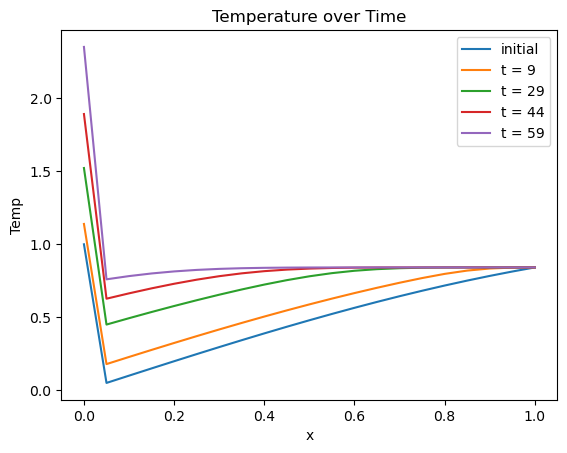

In [34]:
grid = fd1dGrid(20)
pde = advectionPDE(lambda x : np.sin(x), lambda x: np.exp(x), bndy_type = 'Dirichlet', source = lambda x,t: 0*np.sin(x)*np.cos(t))
xpts, u = advec_FE_1D(grid, pde)

plotPDE(xpts, u)

### Linear heat equation
\begin{align}
\frac{\partial}{\partial t} u + a \frac{\partial^2}{\partial x^2} u &= 0
\end{align}

Just like above, we will start with the semidiscrete method. Since we have $u_{xx}$, we will discretize this using the standard 3-point stencil, where $x_i = ih, i = 0,\cdots, n+1, h = \frac{1}{n+1}$.

\begin{align}
u_{xx}(t, x_i) &\approx \frac{u(t, x_{i+1}) - 2u(t,x_i) + u(t,x_{i-1})}{h^2}
\end{align}
but we let $y_i(t) \approx u(t,x_i)$. Assuming the boundary conditions $y_0(t)$ and $y_{n+1}(t)$ are identically zero, and from the initial conditions, $y_i(0) = f(x_i), i = 1,\cdots, n$. We get the following system

\begin{align}
\mathbf{y}' &= \frac{a}{h^2}\begin{pmatrix} -2& 1 & 0 &\cdots & 0\\ 1& -2 &1 &\cdots & 0\\ 0 & 1& -2 & \cdots & 0\\ \vdots &\ddots & \ddots & \ddots & \vdots\\ 0 & \cdots & 0 & 1 & -2\end{pmatrix}\mathbf{y} = \mathbf{Ay}
\end{align}

The Jacobian matrix $\mathbf{A}$ of this system has eigenvalues between $-4ah^{-2}$ and 0, which makes the ODE very stiff as $h\ll 1$. This means we have to use a stiff ODE solver.

In [16]:
def fd3d(nx, ny, nz, cx = 1, cy = 1, cz = 1, alpx = 0, alpy = 0, alpz = 0, dshift = 0, *, is_sparse: bool = False):
    if is_sparse == False:
        # Create tridiagonal matrices tx, ty, and tz
        tx = cx * tridiag(-1+alpx, 2, -1-alpx, nx)
        # If there is enough gridpoints, we use a second order forward method for the left point,
        # and second order backward method for the right point. Now all O(h^2)
        if nx > 3:
            tx[0, :4] = np.array([2,-5,4,-1])
            tx[nx-1,-4:] = np.array([-1,4,-5,2])
        
    
        # Compute A using Kronecker products
        A = tx
        if ny > 1:
            ty = cy * tridiag(-1+alpy, 2, -1-alpy, ny)
            if ny > 3:
                ty[0, :4] = np.array([2,-5,4,-1])
                ty[ny-1,-4:] = np.array([-1,4,-5,2])
            A = np.kron(np.eye(ny), A) + np.kron(ty,np.eye(nx))
            if nz > 1:
                tz = cz * tridiag(-1+alpz, 2, -1-alpz, nz)
                if nz > 3:
                    tz[0, :4] = np.array([2,-5,4,-1])
                    tz[ny-1,-4:] = np.array([-1,4,-5,2])
                A = np.kron(np.eye(nz), A) + np.kron(tz,np.eye(nx * ny))
    
        A -= dshift * np.eye(nx * ny * nz)
    else:
       # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(-1+alpx, 2, -1-alpx, nx, is_sparse = True)
        ty = tridiag(-1+alpy, 2, -1-alpy, ny, is_sparse = True)
        tz = tridiag(-1+alpz, 2, -1-alpz, nz, is_sparse = True) 

        # Create sparse kroneckers
        A = tx
        if ny > 1:
            A = sp.sparse.kron(sp.sparse.identity(ny),A) + sp.sparse.kron(ty,sp.sparse.identity(nx))
            if nz > 1:
                A = sp.sparse.kron(sp.sparse.identity(nz),A) + sp.sparse.kron(tz,sp.sparse.identity(nx * ny))

        A -= dshift * sp.sparse.identity(nx * ny * nz)
    return A

In [17]:
A = fd3d(4,4,1)
B = fd3d(2,2,3, is_sparse = True)

print(B)

  (0, 0)	6.0
  (0, 1)	-1.0
  (0, 2)	-1.0
  (0, 3)	0.0
  (1, 0)	-1.0
  (1, 1)	6.0
  (1, 2)	0.0
  (1, 3)	-1.0
  (2, 0)	-1.0
  (2, 1)	0.0
  (2, 2)	6.0
  (2, 3)	-1.0
  (3, 0)	0.0
  (3, 1)	-1.0
  (3, 2)	-1.0
  (3, 3)	6.0
  (0, 4)	-1.0
  (0, 5)	0.0
  (0, 6)	0.0
  (0, 7)	0.0
  (1, 4)	0.0
  (1, 5)	-1.0
  (1, 6)	0.0
  (1, 7)	0.0
  (2, 4)	0.0
  :	:
  (9, 7)	0.0
  (10, 4)	0.0
  (10, 5)	0.0
  (10, 6)	-1.0
  (10, 7)	0.0
  (11, 4)	0.0
  (11, 5)	0.0
  (11, 6)	0.0
  (11, 7)	-1.0
  (8, 8)	6.0
  (8, 9)	-1.0
  (8, 10)	-1.0
  (8, 11)	0.0
  (9, 8)	-1.0
  (9, 9)	6.0
  (9, 10)	0.0
  (9, 11)	-1.0
  (10, 8)	-1.0
  (10, 9)	0.0
  (10, 10)	6.0
  (10, 11)	-1.0
  (11, 8)	0.0
  (11, 9)	-1.0
  (11, 10)	-1.0
  (11, 11)	6.0


Now that we were able to construct $\mathbf{y}' = \mathbf{Ay}$, where $A$ is a sparse linear system, we need to be able to solve this system. For 1D problems, we have a simple tridiagonal matrix, so we will use the direct method to solve this problem, but for 2D or 3D, the bandwidth is no longer efficient for solving using a direct way. This is where we will employ a few iterative algorithms like GMRES or PCG. 


### Fully discrete method
#### Explicit

We are now going to discretize time as well, so we will have a $1+1$ degree mesh and use a finite difference approximation.

\begin{align}
\frac{u_i^{k+1} - u_i^k}{\Delta t} - a\frac{u_{i+1}^k - 2u_i^k + u_{i-1}^k}{(\Delta x)^2} &= 0, \quad i = 1,\cdots, n
\end{align}
which we rearrange to get

\begin{align}
u_i^{k+1} &= u_i^k + a\frac{\Delta t}{(\Delta x)^2}\left( u_{i+1}^k - 2u_i^k + u_{i-1}^k\right), \quad i = 1,\cdots, n.
\end{align}

This gives us a fully explicit method as we are marching points forward in time, and all necessary information is already known. This comes from the fact that we have the boundary conditions $u_0^k = \alpha, u_{n+1}^k = \beta,\forall k$, and we have $u(x,t) = u_i^0$.


In [18]:
def lp_err(f1, f2, *, p = 2):
    """
    Computes the lp-norm of the difference
    between a function f1 and a function f2
    
    Parameters
    ----------
    f1 : array of floats
        function 1
    f2 : array of floats
        function 2
    p  : power of the norm (default p = 2)
    
    Returns
    -------
    err : float
        The lp-norm of the difference if 1<=p< infty
        The max value of the difference if p = infty
        Error : not a norm if p<1
    """
    if p < 1:
        raise NormError('Not a norm')
    elif p == np.inf:
        lp_err = np.max(np.abs(f1) - np.abs(f2)) / f1.shape[0]
    else:
        lp_err = ((np.sum(np.abs(f1 - f2)** p)) ** (p ** -1)) / f1.shape[0]
    
    return lp_err


In [19]:
class FDGrid:
    """
    a finite-difference grid for any dimension Cartesian Grid
    """

    def __init__(self, dim, np, ng = 1, min_coord=0.0, max_coord=1.0):
        """
        create a 1D grid with (nx + 1) points that runs from [xmin, xmax].
        Additionally calculates dx and the x values where the solution is computed.
        """

        for i  in range(dim):
            self.xmin = xmin
            self.xmax = xmax
            self.ng = ng
            self.nx = nx

In [20]:
class diffusionPDE1:
    """
    a way to store all of the information of the PDE
    """
    
    def __init__(self, init_cond, bndy_condL, bndy_condR, bndy_type = 'Dirichlet', dim = 1, a = 1., source = 0, bndy_condLf = 0, bndy_condRf = 0):
        self.init_cond = init_cond
        self.bndy_type = bndy_type
        if bndy_type == 'Dirichlet':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
        elif bndy_type == 'Neumann':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
        elif bndy_type == 'Robin':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
            self.bndy_condLf = bndy_condLf
            self.bndy_condRf = bndy_condRf
            
        
        self.dim = dim
        self.a = a
        self.source = source # homogenous if source term, f := 0

In [21]:
class diffusionPDE2:
    """
    a way to store all of the information of the PDE
    """
    
    def __init__(self, init_cond, bndy_condL, bndy_condR, bndy_type = 'Dirichlet', dim = 1, a = 1., f = 0, bndy_condLf = 0, bndy_condRf = 0):
        self.init_cond = init_cond
        self.bndy_type = bndy_type
        if bndy_type == 'Dirichlet':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
        elif bndy_type == 'Neumann':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
        elif bndy_type == 'Robin':
            self.bndy_condL = bndy_condL
            self.bndy_condR = bndy_condR
            self.bndy_condLf = bndy_condLf
            self.bndy_condRf = bndy_condRf
            
        
        self.dim = dim
        self.a = a
        self.f = f # homogenous if f := 0

In [22]:
def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

In [23]:
def heat_funSol(x, t, n):
    if t <= 0:
        phi = 0
    else:
        phi = (1./(4 * np.pi * t)) ** (n / 2) * np.exp((-np.abs(x) ** 2) / (4 * t))
    return phi

In [24]:
def heat_FE_1D(grid, pde):
    
    # Grid Params
    n = grid.nx
    dx = grid.dx
    xpts = grid.xpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    C = 0.49
    dt = C * grid.dx ** 2 / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda x: np.exp(x) 
    # b = lambda x: np.exp(x) * np.sin(1)
    al = pde.bndy_condL
    ar = pde.bndy_condR
    if bc == 'Neumann':
        mu = al
        nu = ar
        al = lambda x : 0
        ar = al
        bc = 'Robin'
        print('Successsss.')

    # Solution and applying IC, BCs
    u = np.zeros((n+1, maxk + 1), dtype = float)
    u[:,0] = f(xpts)
    u[0,:] = al(tpts)
    u[n,:] = ar(tpts)
    

    if bc == 'Dirichlet':
        # Constructing (I + cL) where L is the difference operator with bc
        IpcL = tridiag(C, 1 - 2*C,C,n+1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I + cL).
        IpcL[0,:2] = 0
        IpcL[n,-2:] = 0

        for k in range(maxk):
            # Applying the difference operator to the solution, then applying BCs
            u[:,k+1] =  np.dot(IpcL, u[:,k]) + dt * source(xpts,tpts[k])
            u[0,k+1] = al(tpts[k+1])
            u[n,k+1] = ar(tpts[k+1])
    elif bc == 'Robin':
        L = tridiag(1, -2,1,n+1)
        for k in range(maxk):
            # Constructing the difference operator with bc. 
            L[0,0:2] = np.array([-2 * (1 + dx * a(tpts[k])), 2])
            L[n,n-2:n] = np.array([2, -2 * (1 + dx * b(tpts[k]))])
            
            # Difference operator update through time
            IpcL = np.eye(n+1) + C * L
            u[:,k+1] =  np.dot(IpcL, u[:,k]) + dt * source(xpts,tpts[k+1])
            
            # Applying BC for Neumann term
            u[0,k+1] += -2* (dt / dx) * mu(tpts[k])
            u[n,k+1] += -2* (dt / dx) * nu(tpts[k])
    else: # Periodic
        print('Need to do this still')
    
        
    
    return xpts, u

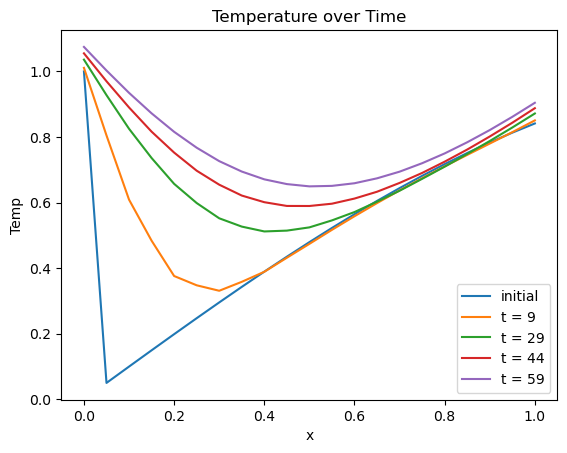

In [33]:
grid = fd1dGrid(20)
pde = diffusionPDE1(lambda x : np.sin(x), lambda x: np.exp(x), lambda x: np.exp(x) * np.sin(1), bndy_type = 'Dirichlet', source = lambda x,t: 0*np.sin(x)*np.cos(t))
xpts, u = heat_FE_1D(grid, pde)

plotPDE(xpts, u)

In [26]:
def heat_FE_2D(grid, pde):
    
    # Grid Params
    # These were all changed pending the new grid class for all grid dims
    nx, ny = grid.nx, grid.nx
    dx, dy = grid.dx, grid.dx
    xpts, ypts = grid.xpts, grid.xpts
    
    
    # PDE Params
    a = 1#pde.a 
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    Cx = 0.49
    Cy = 0.49
    dtx = Cx * grid.dx ** 2 / a
    dty = Cy * grid.dx ** 2 / a
    tpts = np.arange(t0, tf, dtx)
    maxk = 10 #len(tpts) - 1

    # Initial condition function
    # f = lambda x: np.sin(x)
    f = lambda x,y: 0.0
    #f = pde.init_cond
    
    # Boundary Values
    # Left, Right, Top, and Bottom BC (Dirichlet)
    al = lambda t: 0.0
    ar = lambda t: 0.0
    ab = lambda t: 0.0
    at = lambda t: 100.0
    #al = pde.bndy_condL
    #ar = pde.bndy_condR
    #at = pde.bndy_condT
    #ab = pde.bndy_condB

    # Solution and applying IC, BCs
    u = np.zeros((nx+1, ny+1, maxk + 1), dtype = float)
    u[:,:,0] = f(xpts, ypts)
    u[0,:,:] = al(tpts)
    u[nx,:,:] = ar(tpts)
    u[:,0,:] = ab(tpts)
    u[:,nx,:] = at(tpts)
    
    #U = np.zeros(((nx + 1) * (ny + 1), maxk + 1), dtype = float)
    U = u.reshape(((nx + 1) * (ny + 1), maxk + 1), order = 'F' ) # Column stacking
    for k in range(maxk):
        # I + cL
        L = fd3d(nx+1, ny+1, 1, cx = dx ** -2 , cy = dy ** -2)
        IpcL = np.eye((nx + 1) * (ny + 1)) + dtx * L
        U[:,k+1] = L @ U[:,k]
        U[:ny+1, k+1] = al(tpts[k+1])
        U[-ny-1:, k+1] = ar(tpts[k+1])
        U[ny+2:ny+1:, k+1] = at(tpts[k+1])
        U[2*ny+1:ny+1:, k+1] = ab(tpts[k+1])

    u = U.reshape((nx+1, ny+1, maxk + 1), order = 'F')
    
    
    return dtx, maxk, u

In [27]:
grid = fd1dGrid(10)
pde = diffusionPDE1(lambda x : np.sin(x), lambda x: np.exp(x), lambda x: np.exp(x) * np.sin(1), bndy_type = 'Dirichlet')
dtx, maxk, u = heat_FE_2D(grid, pde)

#plotPDE(xpts, u)

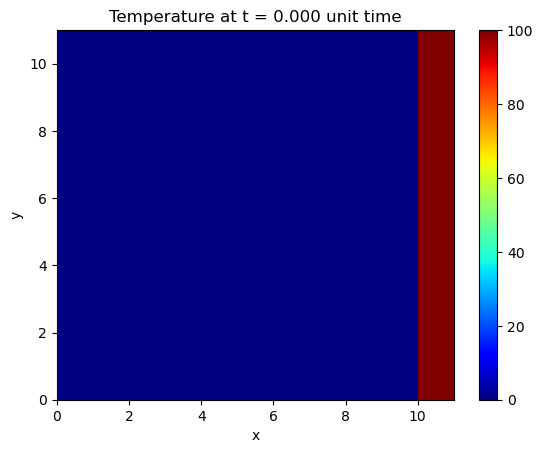

In [28]:
def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*dtx:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
#xpts, ypts, maxk, u = heat_FE_2D()

def animate(k):
    plotheatmap(u[:,:,k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=maxk, repeat=False)


#### Implicit

\begin{align}
u_{i}^{k+1} &= u_i^k + a\frac{\Delta t}{\left(\Delta x\right)^2} \left(u_{i+1}^{k+1} - 2 u_i^{k+1} + u_{i-1}^{k+1}\right)
\end{align}

But observe that we can rewrite this by moving all the future terms on one side and the current time terms on the other. This results in the following equation:
\begin{align}
u_{i}^{n+1} - \frac{\alpha\Delta t}{(\Delta x)^2}\left( u_{i-1}^{n+1} - 2 u_{i}^{n+1} + u_{i+1}^{n+1}\right) &= u_{i}^{n}\\
\left(\mathbf{I} - c\mathbf{A}\right) \mathbf{u}^{n+1} &= \mathbf{u}^n
\end{align}

This should not suprise us that to solve the implicit method there is a linear system solve involved (think Backward Euler's). Since we know that $\mathbf{I} - c\mathbf{A}$ has tridiagonal structure in the 1D diffusion case, we will use a direct solver for this (no fill in with LU).

In [29]:
def heat_BE_1D(grid, pde):
    
    # Grid Params
    n = grid.nx
    dx = grid.dx
    xpts = grid.xpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    C = 0.49
    dt = C * grid.dx ** 2 / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda x: np.exp(x) 
    # b = lambda x: np.exp(x) * np.sin(1) 
    al = pde.bndy_condL
    ar = pde.bndy_condR
    
    mu = lambda x: np.sin(1) * 0
    nu = lambda x: np.cos(1) * 0

    # Solution and applying IC, BCs
    u = np.zeros((n+1, maxk + 1), dtype = float)
    u[:,0] = f(xpts)
    u[0,:] = al(tpts)
    u[n,:] = ar(tpts)
    

    if bc == 'Dirichlet':
        # Constructing Difference Operator
        ImcL = tridiag(-C, 1 + 2*C,-C,n+1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I - cL).
        ImcL[0,:2]  = np.array([1,0])
        ImcL[n,-2:] = np.array([0,1])

        # For Banded Solve (Note because bc, I-cL NOT symmetric)
        supdiag = np.append([0], np.diag(ImcL,1))
        subdiag = np.append(np.diag(ImcL,-1),[0])
        ab = np.array([supdiag, np.diag(ImcL), subdiag])
        for k in range(maxk):
            # Update BCs for solution
            u[:,k] += dt * source(xpts,tpts[k+1])
            u[0,k] = al(tpts[k+1])
            u[n,k] = ar(tpts[k+1])
            
            # Solve at new time step
            #u[:,k+1] = np.linalg.inv(ImcL) @ u[:,k]
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
    elif bc == 'Robin':
        L = tridiag(1, -2,1,n+1)
        for k in range(maxk):
            # Update BCs (Neumann)
            u[:,k] += dt * source(xpts,tpts[k+1])
            u[0,k] += -2* (dt / dx) * mu(tpts[k+1])
            u[n,k] += -2* (dt / dx) * nu(tpts[k+1])

            # Updating difference operator with BC
            L[0,:1] = np.array([-2 * (1 + dx * al(tpts[k+1])), 2])
            L[n,-2:] = np.array([2, -2 * (1 + dx * ar(tpts[k+1]))])
            
            ImcL = np.eye(n+1) - C * L
            # For Banded Solve (Note because bc, I-cL NOT symmetric)
            supdiag = np.append([0], np.diag(ImcL,1))
            subdiag = np.append(np.diag(ImcL,-1),[0])
            ab = np.array([supdiag, np.diag(ImcL), subdiag])
            # Solve Implicit Euler here
            #u[:,k+1] =  np.linalg.inv(ImcL) @ u[:,k]
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
            
    else: # periodic
        print('Not done yet')
    
        
    
    return xpts, u

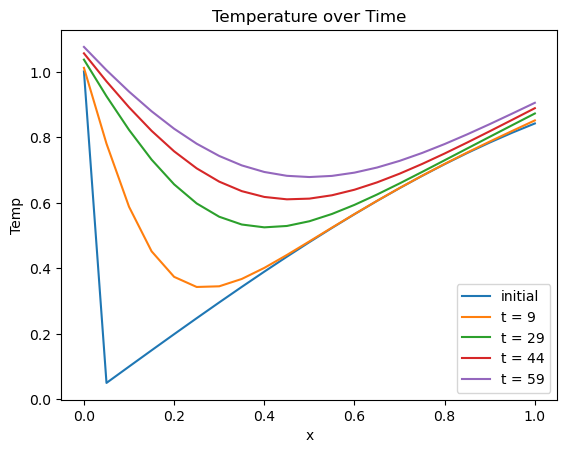

In [30]:
grid = fd1dGrid(20)
pde = diffusionPDE1(lambda x: np.sin(x), lambda t: np.exp(t), lambda t: np.sin(1)*np.exp(t), source = lambda x,t: np.sin(x)*np.exp(t))
xpts, u = heat_BE_1D(grid, pde)

plotPDE(xpts, u)

#### Crank - Nicholson

Lastly, there is 

\begin{align}
u_{i}^{k+1} &= u_i^k + \frac{a}{2}\frac{\Delta t}{\left(\Delta x\right)^2} \left(u_{i+1}^{k+1} - 2 u_i^{k+1} + u_{i-1}^{k+1} + u_{i+1}^k - 2u_i^k + u_{i-1}^k \right)
\end{align}

which is unconditionally stable and second order in time as well. We then rewrite this in terms of matrix equations, by separating the future time steps and the current time steps, as above.

\begin{align}
u_{i}^{n+1} - \frac{\alpha\Delta t}{(\Delta x)^2}\left( u_{i-1}^{n+1} - 2 u_{i}^{n+1} + u_{i+1}^{n+1}\right) &= u_{i}^{n} + \frac{\alpha\Delta t}{(\Delta x)^2}\left( u_{i-1}^{n+1} - 2 u_{i}^{n+1} + u_{i+1}^{n+1}\right)\\
\left(\mathbf{I} - \frac{c}{2}\mathbf{A}\right) \mathbf{u}^{n+1} &= \left(\mathbf{I} + \frac{c}{2}\mathbf{A}\right)\mathbf{u}^n
\end{align}

Now we end up with another linear system solve at each step, where the system is tridiagonal and SPD. We do the same procedure as above. Again, I want to note that for higher dimension problems, we would NOT use the sparse banded solve. We would actually do an inner loop of an iterative method, like PCG, GMRES, GCR.

In [31]:
def heat_CN_1D(grid, pde):
    
    # Grid Params
    n = grid.nx
    dx = grid.dx
    xpts = grid.xpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = (grid.xmax - grid.xmin)/ a
    C = 0.49
    dt = C * grid.dx ** 2 / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda t: np.exp(t) 
    # b = lambda t: np.exp(t) * np.sin(1) 
    al = pde.bndy_condL
    ar = pde.bndy_condR
    
    mu = lambda x: np.sin(1) * 0
    nu = lambda x: np.cos(1) * 0

    # Solution and applying IC, BCs
    u = np.zeros((n+1, maxk + 1), dtype = float)
    u[:,0] = f(xpts)
    u[0,:] = al(tpts)
    u[n,:] = ar(tpts)
    

    if bc == 'Dirichlet':
        # Constructing Difference Operator
        cL = tridiag(C/2,-C,C/2,n+1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I - cL).
        cL[0, :2], cL[n, -2:] = 0,0
        IpcL = np.eye(n+1) + cL
        ImcL = np.eye(n+1) - cL
        
        # For Banded Solve (Note because bc, I-cL NOT symmetric)
        supdiag = np.append([0], np.diag(ImcL,1))
        subdiag = np.append(np.diag(ImcL,-1),[0])
        ab = np.array([supdiag, np.diag(ImcL), subdiag])
        for k in range(maxk):
            # Applying the difference operator to the solution, then applying BCs
            tmp =  np.dot(IpcL, u[:,k]) + 0.5*dt * (source(xpts,tpts[k]) + source(xpts,tpts[k+1]))
            tmp[0] = al(tpts[k+1])
            tmp[n] = ar(tpts[k+1])
            
            # Solve at new time step
            #u[:,k+1] = np.linalg.inv(ImcL) @ tmp
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
    elif bc == 'Robin':
        L = tridiag(1, -2,1,n+1)
        for k in range(maxk):
            # First Sweep of CN
            L[0,:1] = np.array([-2 * (1 + dx * al(tpts[k])), 2])
            L[n,-2:] = np.array([2, -2 * (1 + dx * ar(tpts[k]))])
            IpcL = np.eye(n+1) + C * L
            u[:,k] = IpcL @ u[:,k] + 0.5*dt * (source(xpts,tpts[k]) + source(xpts,tpts[k+1]))
            
            # Update BCs (Neumann)
            u[0,k] += -(dt / dx) * (mu(tpts[k]) + mu(tpts[k+1]))
            u[n,k] += -(dt / dx) * (nu(tpts[k]) + nu(tpts[k+1]))

            # Second Sweep of CN
            L[0,0] = np.array([-2 * (1 + dx * al(tpts[k+1]))])
            L[n,n] = np.array([-2 * (1 + dx * ar(tpts[k+1]))])

            ImcL = np.eye(n+1) - C * L
            # Solve Implicit Euler here
            # For Banded Solve (Note because bc, I-cL NOT symmetric)
            supdiag = np.append([0], np.diag(ImcL,1))
            subdiag = np.append(np.diag(ImcL,-1),[0])
            ab = np.array([supdiag, np.diag(ImcL), subdiag])
            #u[:,k+1] =  np.linalg.inv(ImcL) @ u[:,k]
            u[:,k+1] =  sp.linalg.solve_banded((1,1), ab, u[:,k])
            
    else: # periodic
        print('Not done yet')
    
        
    
    return xpts, u

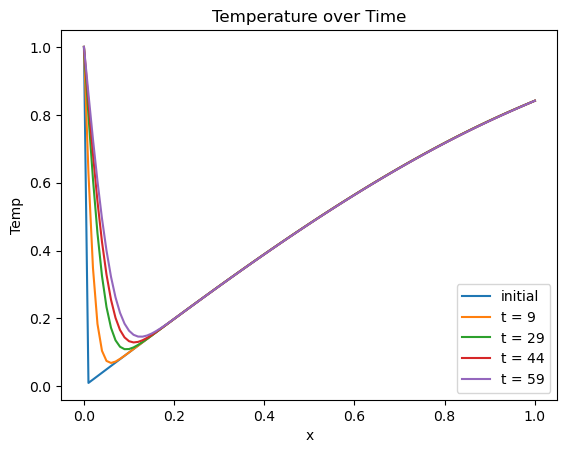

In [32]:
grid = fd1dGrid(100)
pde = diffusionPDE1(lambda x: np.sin(x), lambda t: np.exp(t), lambda t: np.sin(1)*np.exp(t), source = lambda x,t : np.sin(x)*np.exp(t))
xpts, u = heat_CN_1D(grid, pde)

plotPDE(xpts, u)

The above analysis that motivates FE, BE, and CN has plenty of assumptions, such as a homogenous PDE with homogenous Dirichlet boundary conditions, which really makes the code easy. In summary, they are:
| Method | Update Scheme |
| --- | --- |
| FE: | $\mathbf{U}^{n+1} = \left(\mathbf{I} + \Delta t\mathbf{L}\right)\mathbf{U}^{n} $ |
| BE: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \Delta t\mathbf{L}\right)^{-1}\mathbf{U}^{n} $ |
| CN: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \frac{\Delta t}{2}\mathbf{L}\right)^{-1}\left(\mathbf{I} + \frac{\Delta t}{2}\mathbf{L}\right)\mathbf{U}^{n} $ |

Below I will give a brief summary of the most general case for all of the problems:

##### Assume Dirichlet Boundary Conditions
We are using the difference operator as the standard (1,-2,1) stencil but we are also considering boundary conditions so we define the difference operator as 
\begin{align}
\mathbf{L} &= \frac{1}{h^2}\begin{pmatrix} 0 & 0 &&&&\\
1 & -2 & 1 &&&\\
&1&-2&1&&\\
&&&\ddots&\\
&&&0&0
\end{pmatrix},
\end{align}
where the zeros come from the addition of the boundary nodes, subject to the boundary conditions on both sides. Speaking of boundary conditions, we need to make sure that we enforce them everywhere, so since we have just zeroed them out in the difference operator, we need to reassert them by the boundary operator, defined in the following way:
\begin{align}
\mathbf{B}^n\mathbf{U}^n &= \mathbf{B}^n\begin{pmatrix} U^n_0\\ U_1^n\\ \vdots \\ U_n^n\end{pmatrix} = \begin{pmatrix} \gamma_0^n\\ U_1^n\\ \vdots \\ \gamma_n^n\end{pmatrix},
\end{align}
where $U_i^j$ is the solution at $i\Delta x$ at time $j\Delta t$. This leads to the following more general update schemes of FE, BE, and CN:

| Method | Update Scheme |
| --- | --- |
| FE: | $\mathbf{U}^{n+1} = \mathbf{B}^{n+1}\left(\mathbf{I} + \Delta t\mathbf{L}\right)\mathbf{U}^{n} $ |
| BE: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \Delta t\mathbf{L}\right)^{-1} \mathbf{B}^{n+1}\mathbf{U}^{n} $ |
| CN: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \frac{\Delta t}{2}\mathbf{L}\right)^{-1}\mathbf{B}^{n+1}\left(\mathbf{I} + \frac{\Delta t}{2}\mathbf{L}\right)\mathbf{U}^{n} $ |

However, if there are Neumann or Robin boundary conditions, we have to account for these by approximating the derivative at the end points to get the flux, so we create two new operators, which are small adjustments to the ones we have already seen.

\begin{align}
\mathbf{L} &= \frac{1}{h^2}\begin{pmatrix} -2(1+h\alpha_0^n) & 2 &&&&\\
1 & -2 & 1 &&&\\
&1&-2&1&&\\
&&&\ddots&\\
&&&2&-2(1+h\alpha_n^n)
\end{pmatrix}\\
\mathbf{B}^n\mathbf{U}^n &= \mathbf{B}^n\begin{pmatrix} U^n_0\\ U_1^n\\ \vdots \\ U_n^n\end{pmatrix} = \begin{pmatrix} U^n_0\\ U_1^n\\ \vdots \\ U_n^n\end{pmatrix} + \begin{pmatrix} \frac{-2\Delta t}{h}\gamma_0^n\\ 0\\ \vdots \\  \frac{-2\Delta t}{h}\gamma_n^n\end{pmatrix},
\end{align}

| Method | Update Scheme |
| --- | --- |
| FE: | $\mathbf{U}^{n+1} = \mathbf{B}^{n}\left(\mathbf{I} + \Delta t\mathbf{L}^n\right)\mathbf{U}^{n} $ |
| BE: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \Delta t\mathbf{L}^{n+1}\right)^{-1} \mathbf{B}^{n+1}\mathbf{U}^{n} $ |
| CN: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \frac{\Delta t}{2}\mathbf{L}^{n+1}\right)^{-1}\mathbf{B}^{n+1/2}\left(\mathbf{I} + \frac{\Delta t}{2}\mathbf{L}^n\right)\mathbf{U}^{n} $ |

Notice $\mathbf{B}^{n+1/2}$ is just the average of the boundary conditions at $n$ and $n+1$ time step.

Lastly, for a general linear parabolic equation with source term $g$, we get 
\begin{align}
\frac{\partial}{\partial t} u(x,t) &= \mathcal{L}(x,t)u(x,t) + g(x,t),
\end{align}
we discretize the solution in space-time, we discretize the differential operator into a compact matrix operator and then discretize the source in the same fashion as the solution, namely
\begin{align}
\mathbf{g}^n &= \begin{pmatrix} g_0^n \\g_1^n \\ \vdots \\ g_m^n \end{pmatrix}
\end{align}

Then the schemes become
| Method | Update Scheme |
| --- | --- |
| FE: | $\mathbf{U}^{n+1} = \mathbf{B}\Big(\left(\mathbf{I} + \Delta t\mathbf{L}^n\right)\mathbf{U}^{n} + \Delta t \mathbf{g}^n\Big) $ |
| BE: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \Delta t\mathbf{L}^{n+1}\right)^{-1} \mathbf{B}\Big(\mathbf{U}^{n} + \Delta t \mathbf{g}^{n+1}\Big)$ |
| CN: | $\mathbf{U}^{n+1} = \left(\mathbf{I} - \frac{\Delta t}{2}\mathbf{L}^{n+1}\right)^{-1}\mathbf{B}\Big(\left(\mathbf{I} + \frac{\Delta t}{2}\mathbf{L}^n\right)\mathbf{U}^{n} + \frac{\Delta t}{2}\left( \mathbf{g}^n +  \mathbf{g}^{n+1}\right)\Big) $ |

##### Some thoughts about periodic boundary conditions.

Since we have to enforce that $u(0,t) = u(\ell,t),\forall t$this means we have $u_0^n = u_{\ell}^n$, so for example, we have
\begin{align}
\frac{\partial^2}{\partial x^2} u(0,t) &\approx \frac{1}{h^2}\left(u_{-1}^n - 2u_0^n + u_1^n\right) + \mathcal{O}(h^2)\\
& = \frac{1}{h^2}\left(u_{\ell-1}^n - 2u_0^n + u_1^n\right) + \mathcal{O}(h^2)\\,
\end{align}
or in matrix form, we would have
\begin{align}
\mathbf{L} &= \frac{1}{h^2} \begin{pmatrix}
1 & 0 & \cdots & 1 & -2\\
-2 & 1 & 0 & \cdots & 1\\
1 & -2 & 1 & \cdots & 0\\
0 & \ddots & \ddots & \ddots & 0\\
0 & \cdots & 1 & -2 & 1\\
1 & \cdots & 0 & 1 & -2\\
-2 & 1 & \cdots & 0 &1\\
\end{pmatrix}
\end{align}
For periodic boundary conditions, we no longer get a tridiagonal, or banded matrix. But we almost get a banded matrix. In fact, it only differs 6 places from the original difference operator. Since it is a low rank update to an easily invertible matrix, we might consider Sherman - Morrison - Woodbury to see if we can invert it easily.
\begin{align}
\mathbf{\hat{L}} &= \mathbf{L} + \mathbf{u} \otimes \mathbf{v}
\end{align}

##### Questions 
* Could we use some FMM, or FFT method to solve the 

##### To - Do
* Will we ever need mixed boundary conditions (I guess have more if statements for DirichletNeumann or RobinDirichlet)
* More stability analysis?
* Lax - Wendroff
* RK4
* Lax- Friedrichs scheme for advection
* Racchmarcher time stepping for non C^1 initial conditions